Make an XL image for FGSES. Pad CDS ID fits file from 2048 x 2048 out to 2400 x 2400. Add 5 extra PSFs to the padded area.

In [2]:
import os

from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

from jwst_magic.utils import utils
from jwst_magic.fsw_file_writer import write_files

%matplotlib inline

Using backend:  Qt5Agg
Your MAGIC package is up to date
Your FGS COUNTRATE package is up to date


In [4]:
#####################################################
# USER NEEDS TO CHANGE THESE WITH EACH NEW DATA SET #
#####################################################
# Set input filenames
in_dir = '/user/holfeltz/nelan'
infile = os.path.join(in_dir, 'G1no11_BCF.fits')

In [5]:
#####################################################
# USER NEEDS TO CHANGE THESE WITH EACH NEW DATA SET #
#####################################################
# Set output filenames
out_dir = in_dir
fits_out = os.path.join(out_dir, 'LMC-LRE6_G1_IDcds_XL.fits')
dat_out = os.path.join(out_dir, 'LMC-LRE6_G1_IDcds_XL.dat')

In [ ]:
#####################################################
# USER NEEDS TO CHANGE THESE WITH EACH NEW DATA SET #
#####################################################
# tell us what kind of image this is. 
# The acceptable types are: 'cds', 'ff', 'seed'
#    'cds' : The ID CDS image from MAGIC (in 'stsci_'), we expect this to be a cube in units of counts
#    'ff'  : The Full Frame ID image from MAGIC (in 'stsci_'), we expect this to be a single frame in units of counts
#    'seed': The image in 'FGS_imgs' from MAGIC, this is in units of ADU/s and is lacking any bias information
# Note that the 'seed' image will not account for saturation correctly since we are not calculating it based on the
# different reads

image_type = 'cds'

In [3]:
# PSF locations
psf_template_loc = '/user/holfeltz/simdata/webb_templates/'
opd = 'OPD4'

# Set up variables & indexing stuff
psfx = 101
psfy = 101
image_size = 2048
big_image_size = 2400
pad = big_image_size - image_size
dx = pad//2
dy = dx
half_psf = psfx//2 + 1

In [6]:
# Read input data and header
data, hdr = fits.getdata(infile, ext=0, header=True)

# Make sure that we are only working with one frame in units of counts
if image_type == 'cds':
    data = data[0]
elif image_type == 'ff':
    data = data
elif image_type == 'seed': 
    data = data*0.3406 # Convert to counts
    data = utils.correct_image(data, upper_threshold=65535, upper_limit=65535)

In [7]:
# Initialize output img
obs = np.zeros([big_image_size, big_image_size])   # big output files
obs[dx:dx+image_size, dy:dy+image_size] = data  # small insert/starting file

In [3]:
# Set up variables & indexing stuff
psfx = 101
psfy = 101
image_size = 2048
big_image_size = 2400
pad = big_image_size - image_size
dx = pad//2
dy = dx
half_psf = psfx//2 + 1
# set up dummy arrays with pixel values that equal their x & y coords
x = np.zeros([big_image_size,big_image_size])
y = x
for i in range(big_image_size):
    x[:,i] = i
y = np.rot90(x)
y = np.flipud(y)
# divide up padded area into left, right, top, & bottom regions
# get (ix,iy) indices for where in the 2400x2400 image these pixel are located
pad_all = (np.where((x >= half_psf) & (x <= dx-half_psf) & (y >= half_psf) & (y <= big_image_size-half_psf)) or
    np.where((x >= big_image_size-dx+half_psf) & (x <= big_image_size-half_psf) & (y >= half_psf) & (y <= big_image_size-half_psf)) or
    np.where((y >= half_psf) & (y <= big_image_size-dy+half_psf) & (x >= half_psf) & (x <= big_image_size-half_psf)) or
    np.where((y >= half_psf) & (y <= big_image_size-dy+half_psf) & (x >= half_psf) & (x <= big_image_size-half_psf)))
ss = np.shape(pad_all)
print(ss)
print(ss[1])



(2, 172425)
172425


In [10]:
################################################
# USER MAY CHANGE THESE WITH EACH NEW DATA SET #
################################################
nstars = 25
locount = 15000
hicount = 10000000
# get x & y coords in padded region for each requested pad-star
i = np.random.randint(0, ss[1], size=nstars)
x_rp = []
y_rp = []
for k in range(nstars):
    x_rp.append(pad_all[0][i[k]])
    y_rp.append(pad_all[1][i[k]])
# get counts for each requsted pad-star
adu = np.random.randint(nstars, locount, hicount)

(25,)
(2, 172425)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [8]:
# Add 5 more stars to padded area
nstar = 5

# Star locations
x_rp = np.array([675, 1881, 115, 1363, 2300])
y_rp = np.array([166, 125, 852, 2345, 1650])

# Counts
adu = [99866, 24577, 62197, 104302, 95834]

# PSF identifier for finding the PSF to use
ipsf = ['422', '194', '062', '501', '654']  # PSF file numbers

In [9]:
# Accumulate all stars in FOV at real pixel positions (postage stamps)
for x, y, counts, psf in zip(x_rp, y_rp, adu, ipsf):
    tmp = np.zeros_like(obs)
    x1 = x - psfx//2
    x2 = x + psfx//2 + 1
    y1 = y - psfy//2
    y2 = y + psfy//2 + 1
    
    # use psf templates
    psftemp = os.path.join(psf_template_loc, f'M0V_{opd}_{psf}.fits')
    psfii = fits.getdata(psftemp)
    psfdat = counts * psfii / psfii.sum() # normalize psf
    tmp[x1:x2, y1:y2] = psfdat
    obs += tmp  # add psf to output img

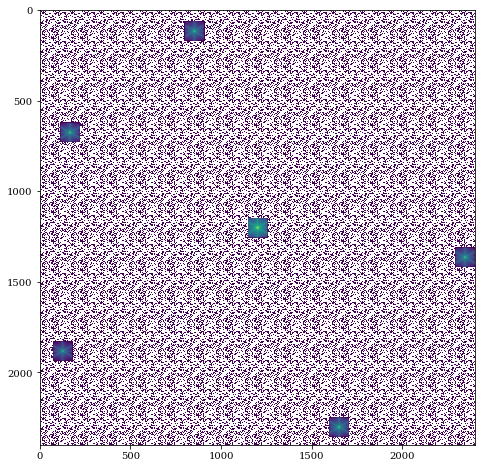

In [12]:
# Plot it out!

plt.figure(figsize=(10, 8))
plt.imshow(obs, norm=LogNorm())
plt.show()

In [ ]:
# write out fits file
print('writing fits file')

utils.write_fits(fits_out, obs, header=hdr)

# write out dat file
for_dat = np.uint16(obs)
flat = for_dat.flatten()
fmt = '{:04X} '
with open(dat_out, 'w') as file_out:
    for dat in flat.astype(np.uint16):
        file_out.write(fmt.format(dat))

print('done')

####  About this notebook:
Author: S. Holfeltz

Updates by: K. Brooks

Last updated: 13 October, 2021